In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy, nltk, gensim
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davitmartirosyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/davitmartirosyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/davitmartirosyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davitmartirosyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reading the data

In [2]:
data_recipe = pd.read_json('data/full_format_recipes.json')

In [3]:
data_recipe.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


In [4]:
data_recipe.shape

(20130, 11)

In [5]:
data_recipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20130 entries, 0 to 20129
Data columns (total 11 columns):
directions     20111 non-null object
fat            15908 non-null float64
date           20111 non-null datetime64[ns, UTC]
categories     20111 non-null object
calories       15976 non-null float64
desc           13495 non-null object
protein        15929 non-null float64
rating         20100 non-null float64
title          20111 non-null object
ingredients    20111 non-null object
sodium         15974 non-null float64
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 1.7+ MB


Let's drop the column 'desc', since we are not going to use it

In [6]:
data_recipe = data_recipe.drop('desc',axis=1)

Let's also remove the rows where the column 'rating' has value 0

In [7]:
data_recipe = data_recipe[data_recipe.rating>0]

Checking the number of null values for each column

In [8]:
data_recipe.isnull().sum()

directions        0
fat            3657
date              0
categories        0
calories       3624
protein        3648
rating            0
title             0
ingredients       0
sodium         3626
dtype: int64

Let's drop all rows with at least one missing value

In [9]:
data_recipe = data_recipe.dropna()

Let's drop also duplicate recipes

In [10]:
data_recipe = data_recipe.drop_duplicates(subset='title')

# resetting index
data_recipe = data_recipe.reset_index(drop=True)

We are left with 13001 rows

In [11]:
data_recipe.shape

(13001, 10)

An example of a recipe

In [12]:
data_recipe.iloc[0]['ingredients']

['4 cups low-sodium vegetable or chicken stock',
 '1 cup dried brown lentils',
 '1/2 cup dried French green lentils',
 '2 stalks celery, chopped',
 '1 large carrot, peeled and chopped',
 '1 sprig fresh thyme',
 '1 teaspoon kosher salt',
 '1 medium tomato, cored, seeded, and diced',
 '1 small Fuji apple, cored and diced',
 '1 tablespoon freshly squeezed lemon juice',
 '2 teaspoons extra-virgin olive oil',
 'Freshly ground black pepper to taste',
 '3 sheets whole-wheat lavash, cut in half crosswise, or 6 (12-inch) flour tortillas',
 '3/4 pound turkey breast, thinly sliced',
 '1/2 head Bibb lettuce']

Second example of a recipe

In [13]:
data_recipe.iloc[1]['ingredients']

['1 1/2 cups whipping cream',
 '2 medium onions, chopped',
 '5 teaspoons salt',
 '3 bay leaves',
 '3 whole cloves',
 '1 large garlic clove, crushed',
 '1 teaspoon pepper',
 '1/8 teaspoon ground nutmeg',
 'Pinch of dried thyme, crumbled',
 '8 large shallots, minced',
 '1 tablespoon butter',
 '1 pound trimmed boneless center pork loin, sinew removed cut into 1-inch chunks, well chilled',
 '3 eggs',
 '6 tablespoon all purpose flour',
 '1/4 cup tawny Port',
 '3 tablespoons dried currants, minced',
 'Lettuce leaves',
 'Cracked peppercorns',
 'Minced fresh parsley',
 'Bay leaves',
 'French bread baguette slices',
 '3 tablespoons olive oil',
 '2 large red onions, halved, sliced',
 '3 tablespoons dried currants',
 '3 tablespoons red wine vinegar',
 '1 tablespoons canned chicken broth',
 '2 teaspoons chopped fresh thyme or 3/4 teaspoon dried, crumbled',
 '1/2 teaspoon sugar']

Let's make the list of strings a single joined string

In [14]:
data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: ' '.join(x))

In [15]:
data_recipe.iloc[0]['ingredients']

'4 cups low-sodium vegetable or chicken stock 1 cup dried brown lentils 1/2 cup dried French green lentils 2 stalks celery, chopped 1 large carrot, peeled and chopped 1 sprig fresh thyme 1 teaspoon kosher salt 1 medium tomato, cored, seeded, and diced 1 small Fuji apple, cored and diced 1 tablespoon freshly squeezed lemon juice 2 teaspoons extra-virgin olive oil Freshly ground black pepper to taste 3 sheets whole-wheat lavash, cut in half crosswise, or 6 (12-inch) flour tortillas 3/4 pound turkey breast, thinly sliced 1/2 head Bibb lettuce'

In [16]:
data_recipe.iloc[1]['ingredients']

'1 1/2 cups whipping cream 2 medium onions, chopped 5 teaspoons salt 3 bay leaves 3 whole cloves 1 large garlic clove, crushed 1 teaspoon pepper 1/8 teaspoon ground nutmeg Pinch of dried thyme, crumbled 8 large shallots, minced 1 tablespoon butter 1 pound trimmed boneless center pork loin, sinew removed cut into 1-inch chunks, well chilled 3 eggs 6 tablespoon all purpose flour 1/4 cup tawny Port 3 tablespoons dried currants, minced Lettuce leaves Cracked peppercorns Minced fresh parsley Bay leaves French bread baguette slices 3 tablespoons olive oil 2 large red onions, halved, sliced 3 tablespoons dried currants 3 tablespoons red wine vinegar 1 tablespoons canned chicken broth 2 teaspoons chopped fresh thyme or 3/4 teaspoon dried, crumbled 1/2 teaspoon sugar'

Let's now make all words lowercase

In [17]:
data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: x.lower())

Defining the units and some common words that need to be removed from recipes

In [18]:
unwanted_words = ['c', 'quarts', 'tbs', 'oz.', 'pinch', 'half', 'coarse', 't', 'liters', 'bunch', 'lb', 'T.', 
                  'glass', 'room', 'cube', 'sprigs', 'round', 'basket', 'gal.', 'pints', 'package', 'teaspoons', 
                  'T', 'bag', 'kilograms', 'tbsp.', 'pot', 'lb.', 'dashes', 'filets', 'jar', 'sprig', 'grill', 
                  'dash', 'specialty', 'slice', 'temperature', 'pan', 'oz', 'kg.', 'large', 'pound', 'touch', 
                  'yam', 'clove', 'box', 'chunk', 'gallon', 'qt.', 'lid', 'qts.', 'kg', 'mail', 'g.', 'fluid ounce', 
                  'cups', 'qts', 'lengthwise', 't.', 'order', 'ml.', 'grocer', 'skillet', 'tsp', 'milligrams', 
                  'milligram', 'kilogram', 'filet', 'gal', 'small', 'handful', 'thick', 'spray', 'cut', 'pt.', 
                  'spoon', 'milliliters', 'shop', 'key', 'pint', 'mg.', 'fl. oz.', 'crosswise', 'fl oz', 'touches', 
                  'liter', 'gr.', 'c.', 'milliliter', 'scoops', 'thin', 'l.', 'supermarket', 'cans', 'medium', 
                  'tsp.', 'ounce', 'g', 'tablespoons', 'tbs.', 'accompaniment', 'market', 'sheet', 'center', 
                  'gallons', 'dice', 'can', 'handfuls', 'tablespoon', 'teaspoon', 'tbsp', 'ml', 'equipment', 
                  'pinches', 'part', 'gr', 'cloves', 'qt', 'ounces', 'grams', 'gram', 'cup', 'stick', 'sticks', 
                  'envelope', 'scoop', 'flake', 'mg', 'l', 'pt', 'pounds', 'fluid ounces', 'quart', 'food', 
                  'microwave', 'piece', 'inch', 'layer', 'top', 'granny', 'triangle', 'note']

In order to extract ingredients from the recipes we are going to apply the following pipeline:

1. Keep only nouns using nltk
2. Remove our defined unwanted words
3. Do lemmatisation using nltk
4. Keep only unique words in the final list

First we need to do tokenization

In [19]:
data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: word_tokenize(x))

Attaching a part of speech tag to each word 

In [20]:
data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: nltk.pos_tag(x))

Keeping only nouns

In [21]:
data_recipe.ingredients = data_recipe.ingredients.apply(
    lambda x: [word for word, pos in x if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')])

Removing our defined unwanted words

In [22]:
data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: [w for w in x if w not in unwanted_words])

Lemmatisation step

In [23]:
wnl = WordNetLemmatizer()
data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: [wnl.lemmatize(token) for token in x])

Removing duplicate words from the final list

In [24]:
# stripping
data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: [each.strip('*/-.,+') for each in x])

data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: list(set(x)))

The result for the first example after applying the pipeline

In [25]:
data_recipe.iloc[0]['ingredients']

['carrot',
 'apple',
 'lentil',
 'tomato',
 'sheet',
 'turkey',
 'stalk',
 'oil',
 'juice',
 'fuji',
 'ground',
 'lettuce',
 'lavash',
 'kosher',
 'stock',
 'breast',
 'thyme',
 'head',
 'pepper',
 'bibb',
 'celery']

The result for the second example after applying the pipeline

In [26]:
data_recipe.iloc[1]['ingredients']

['wine',
 'currant',
 'baguette',
 'sugar',
 'oil',
 'butter',
 'tawny',
 'onion',
 'egg',
 'vinegar',
 'loin',
 'cream',
 'parsley',
 'port',
 'lettuce',
 'ground',
 'chunk',
 'leaf',
 'shallot',
 'thyme',
 'bay',
 'pork',
 'peppercorn',
 'bread',
 'pepper']

They are not perfect but seem good enough :)

Let's look at the distribution of the number of ingredients in recipes

In [27]:
ingredients = data_recipe.ingredients.copy()

In [28]:
l = np.array([len(elem) for elem in ingredients])

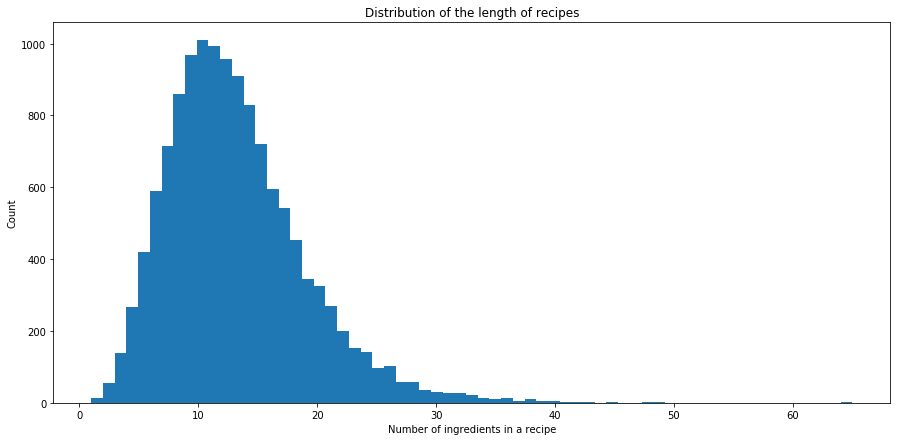

In [29]:
plt.figure(figsize=(15,7))
plt.hist(l,bins=65)
plt.title('Distribution of the length of recipes')
plt.xlabel('Number of ingredients in a recipe')
plt.ylabel('Count')
plt.show()

As we can see from the plot, we have a right-skewed normal distribution.

Given this data, we want to construct a weighted graph with nodes represented by the recipes and connect them based on the common ingredients they share. As a similarity metric between two recipes, we will use Jaccard similarity index which will serve as the weights for the graph.

Since our data is large, we want to keep only a subset of it. Out of the available 13001 recipes, we will take only 5000 based on random sampling.

In [30]:
np.random.seed(42)

node_size = 5000

indicies_to_take = np.random.permutation(data_recipe.shape[0])[:node_size]

Selecting the rows corresponding to the chosen 5000 recipes

In [31]:
new_data_recipe = data_recipe.loc[indicies_to_take]

Now let's build our jaccard similarity matrix 

In [32]:
jaccard_similarity_matrix = np.zeros((node_size,node_size))

new_ingredients = new_data_recipe.ingredients.values

for i in tqdm(range(node_size)):
    for j in range(i,node_size):
        jaccard_similarity_matrix[i,j] = 1 - nltk.jaccard_distance(set(new_ingredients[i]), set(new_ingredients[j]))
        jaccard_similarity_matrix[j,i] = jaccard_similarity_matrix[i,j]

100%|██████████| 5000/5000 [01:08<00:00, 72.93it/s] 


Setting diagonal entries 0

In [33]:
np.fill_diagonal(jaccard_similarity_matrix,0)

Let's take a look at the distribution of the obtained Jaccard similarity values.

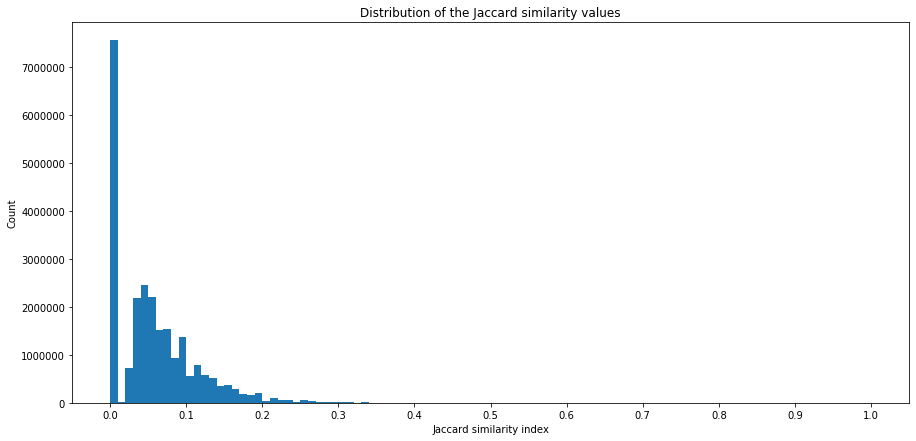

In [34]:
plt.figure(figsize=(15,7))
plt.hist(jaccard_similarity_matrix.flatten(),bins=100)
plt.title('Distribution of the Jaccard similarity values')
plt.xlabel('Jaccard similarity index')
plt.ylabel('Count')
plt.xticks(np.linspace(0,1,11))
plt.show()

In [35]:
print('Number of edges: {}'.format(int(len(jaccard_similarity_matrix[jaccard_similarity_matrix>0])/2)))

Number of edges: 8719604


As we can see, we have enourmous number of edges. Most of them are weakly connected, so let's remove those edges.

In [37]:
threshold = 0.2

jaccard_similarity_matrix[jaccard_similarity_matrix<threshold] = 0

In [38]:
print('Number of edges now: {}'.format(int(len(jaccard_similarity_matrix[jaccard_similarity_matrix>0])/2)))

Number of edges now: 243225


Saving the adjacency matrix as a numpy array

In [39]:
np.save('adjacency_matrix.npy',jaccard_similarity_matrix)

Saving the chosen subset of the processed data

In [40]:
new_data_recipe.to_json('processed_data.json')